<a href="https://colab.research.google.com/github/coldDayss/DSU_AIsys/blob/main/SVM_Gender_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/primaryobjects/voicegender

In [2]:
import pandas as pd
import seaborn as sns
import sys, os
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

데이터를 불러온다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import io
voice_df = pd.read_csv('/content/voice.csv', encoding='cp949')
voice_df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


총 3168개의 음성 샘플들이 있으며 남녀 각각 21개씩의 음향 특징들이 있다.


meanfreq : 평균 주파수 (kHz)
sd : 주파수의 표준 편차
median : 중앙값 주파수 (kHz)
Q25 : 첫 번째 분위수 (kHz)
Q75 : 세 번째 분위수 (kHz)
IQR : 양분 위 범위 (kHz)
skew : 왜도 (specprop 설명의 참고 참조)
kurt : 첨도 (specprop 설명에서 참고 참조)
sp.ent : 스펙트럼 엔트로피
sfm : 스펙트럼 평탄도
mode : 모드 주파수
centroid : 주파수 중심 (specprop 참조)
peakf : 피크 주파수 (에너지가 가장 높은 주파수)
meanfun : 음향 신호에서 측정 된 기본 주파수의 평균
minfun : 음향 신호에서 측정 된 최소 기본 주파수
maxfun : 음향 신호에서 측정 된 최대 기본 주파수
meandom : 음향 신호에서 측정 된 지배 주파수의 평균
mindom : 음향 신호 전반에 걸쳐 측정 된 지배 주파수의 최소값
maxdom : 음향 신호에 걸쳐 측정 된 지배 주파수의 최대 값
dfrange : 음향 신호에서 측정 된 주요 주파수 범위
modindx : 변조 지수. 기본 주파수의 인접 측정 간의 누적 절대 차이를 주파수 범위로 나눈 값으로 계산됩니다.

In [11]:
voice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [12]:
print("성별 인식 데이터셋의 크기 : {}".format(voice_df.shape))

성별 인식 데이터셋의 크기 : (3168, 21)


남녀 음성 데이터들이 각각 1584개로 이루어져있다.

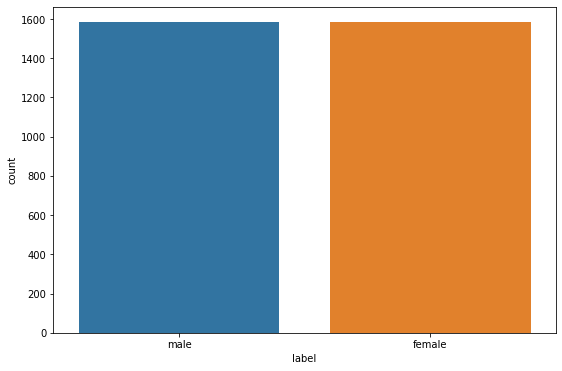

In [13]:
plt.figure(figsize=(9,6))
sns.countplot(x='label', data=voice_df, order=["male", "female"] )

남성, 여성의 목소리 특징들을 그래프로 비교  

In [14]:
label_encode = LabelEncoder()
voice_df['label'] = label_encode.fit_transform(voice_df['label'])

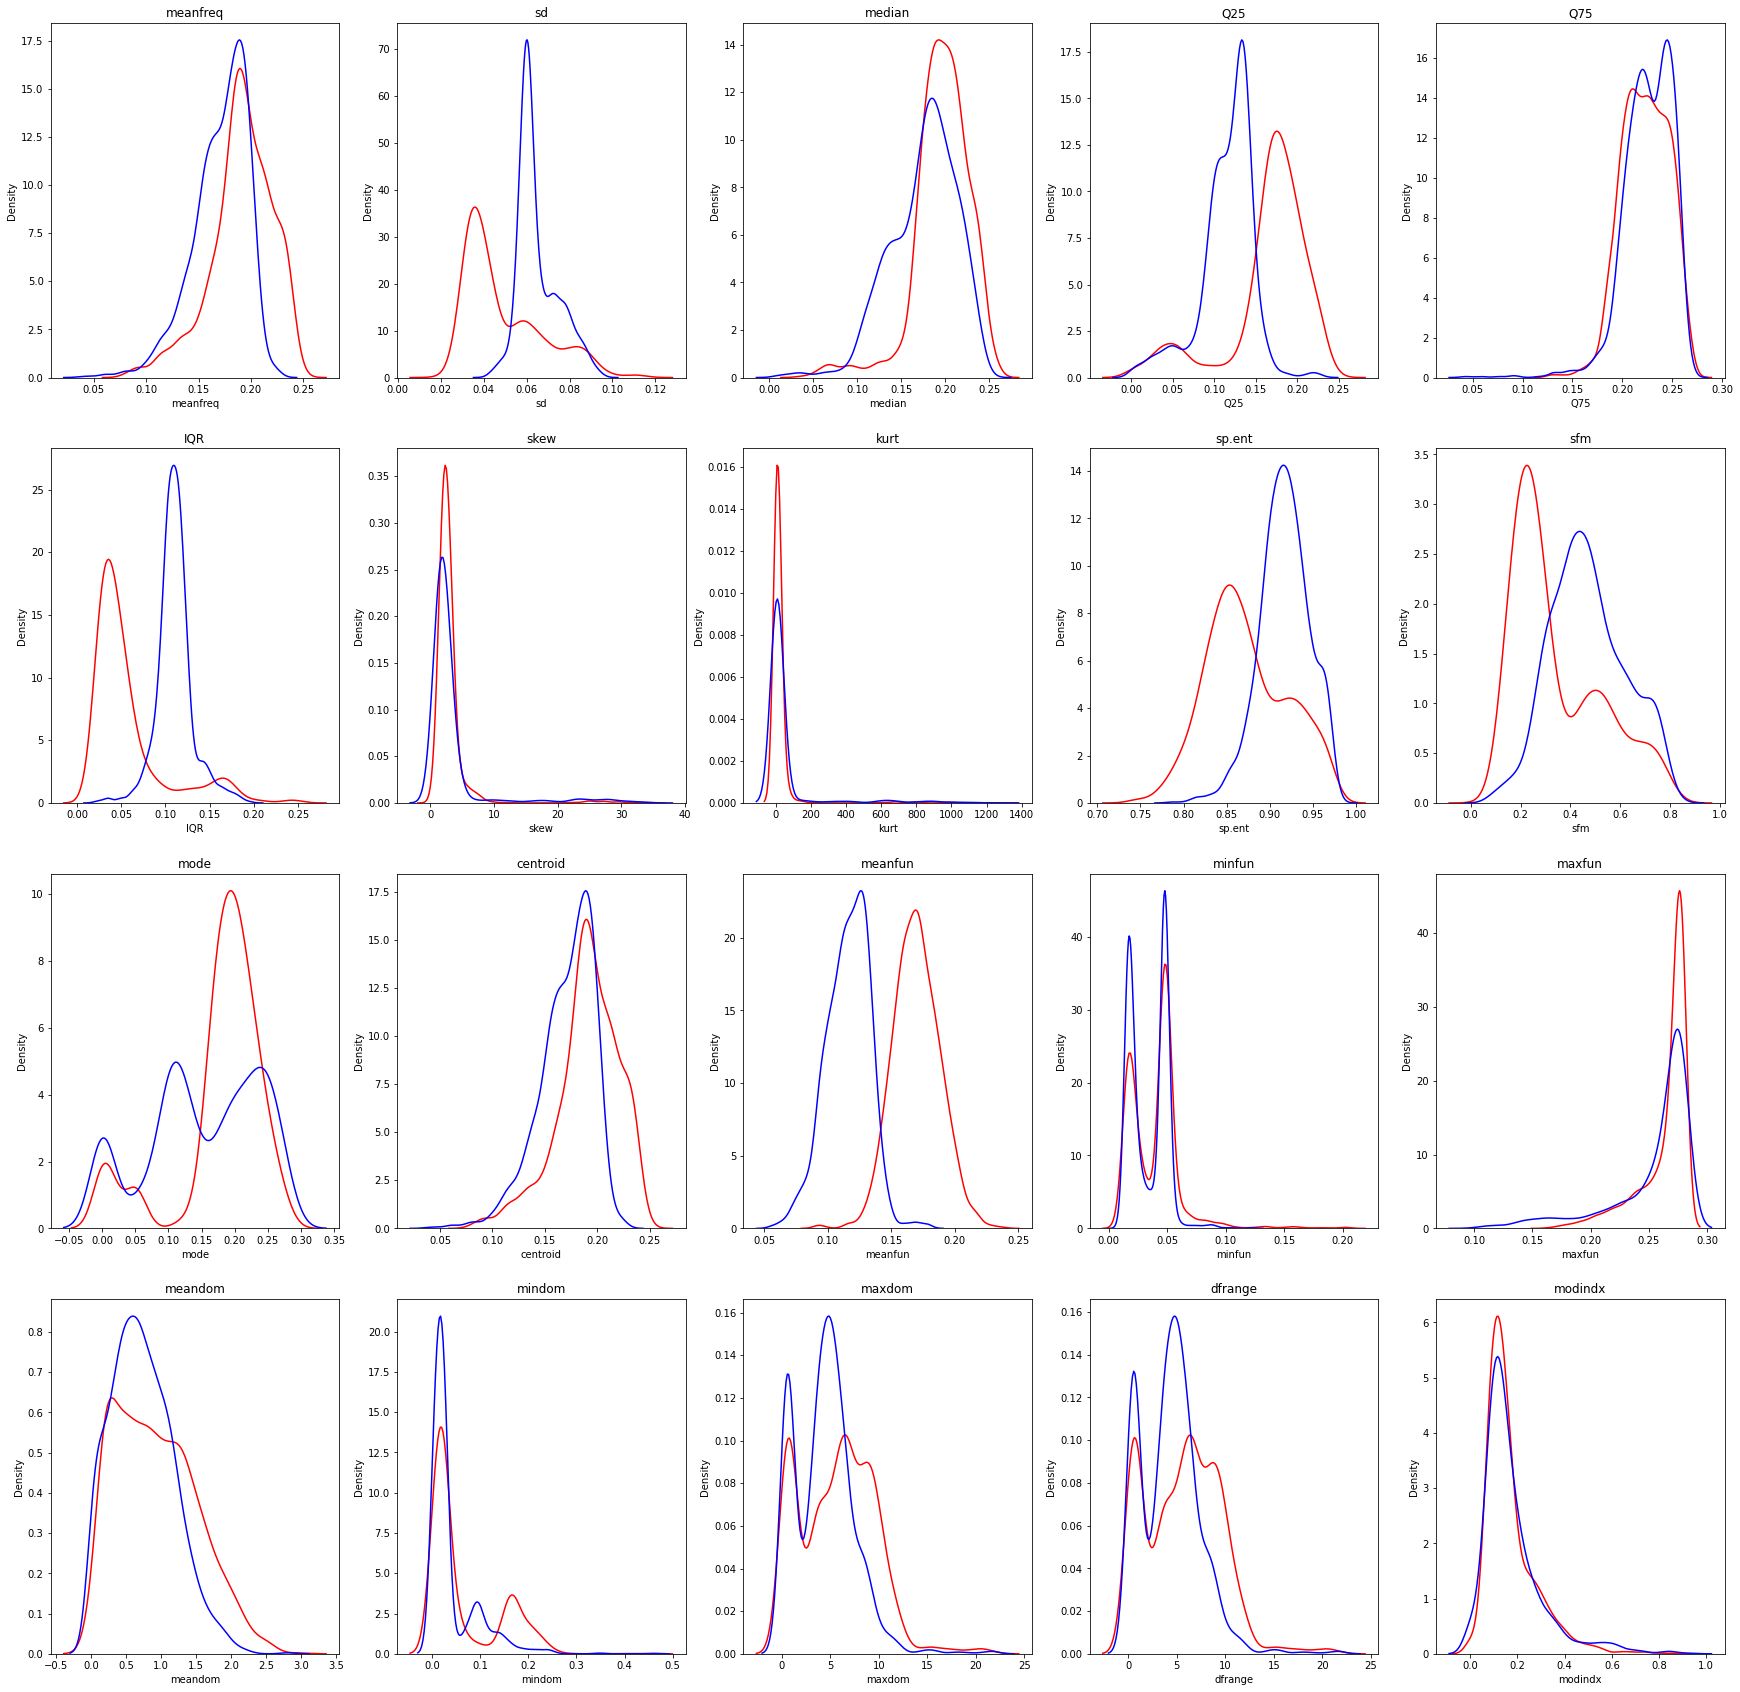

In [15]:
plt.subplots(4,5,figsize=(30,30))
for i in range(1,21):
    plt.subplot(4,5,i)
    plt.title(voice_df.columns[i-1])
    sns.kdeplot(voice_df.loc[voice_df['label'] == 0, voice_df.columns[i-1]], color= 'red', label='female')
    sns.kdeplot(voice_df.loc[voice_df['label'] == 1, voice_df.columns[i-1]], color= 'blue', label='male')

남녀 음성 특징들에 대해 차이가 많은 순으로 나열해보았을때
meanfun(음향 신호에서 측정 된 기본 주파수의 평균)이 가장 차이가 많이 났으며
그 다음 IQR, Q25 순으로 특징 차이가 많이 납니다.

남녀를 구분하기위해 가장 차이가 많이나는 'meanfun', 'IQR', 'Q25' 특징을 가지고
학습을 시킵니다.

Text(0, 0.5, 'Features')

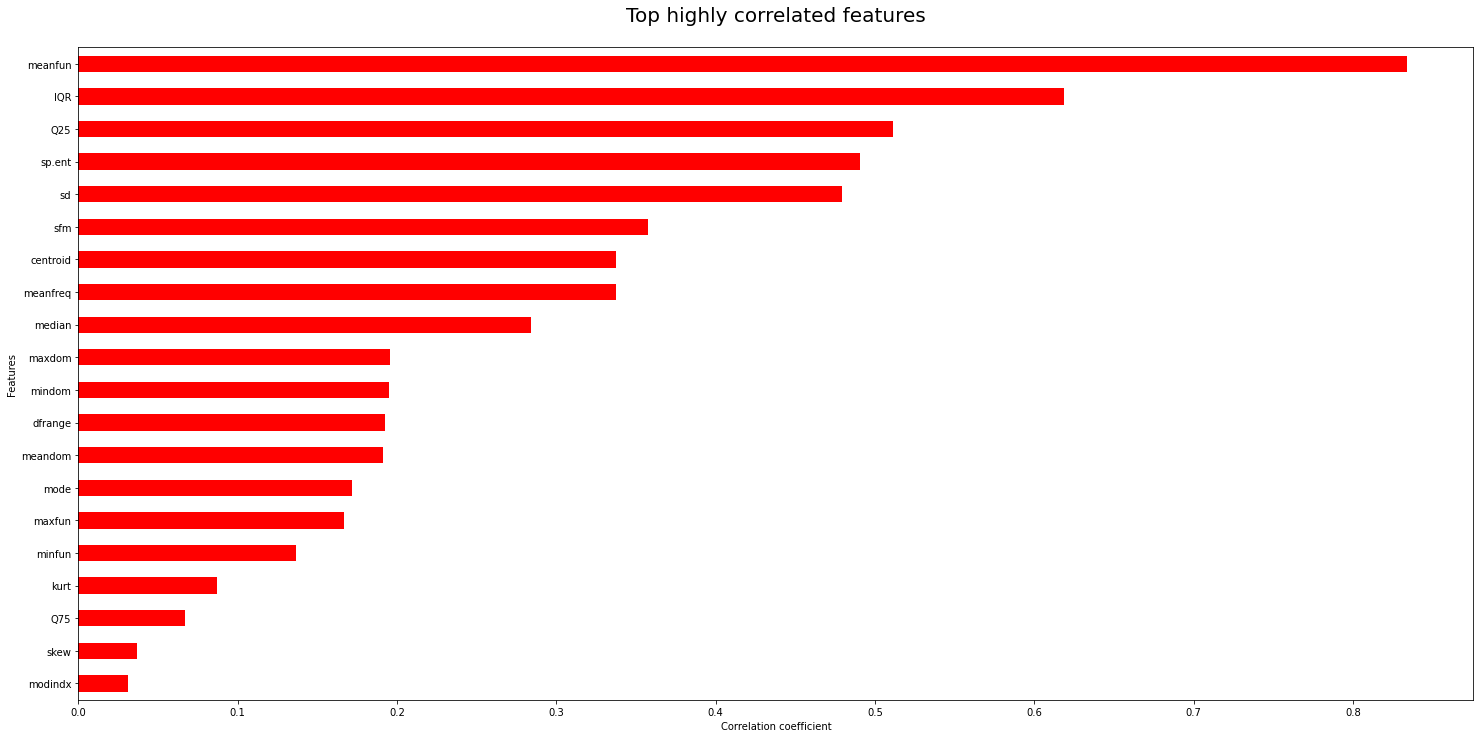

In [16]:
corr_data = voice_df.corr() 
selected_pixel_features = corr_data['label'].apply(lambda x: abs(x)).sort_values(ascending=False).iloc[1:21][::-1]
plt.figure(figsize=(25,12))
selected_pixel_features.plot(kind='barh',color='red')
# calculating highest correlated faetures
# with respect to target variable i.e. "convert"
plt.title("Top highly correlated features", size=20, pad=26)
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

In [17]:
# 특징을 선택
selected_features = ['IQR','Q25','meanfun']

voice_df_X = voice_df[selected_features]
voice_df_y = voice_df.label

voice_df_X.head()

,IQR,Q25,meanfun
0,0.075122,0.015071,0.084279
1,0.073252,0.019414,0.107937
2,0.123207,0.008701,0.098706
3,0.111374,0.096582,0.088965
4,0.127325,0.078720,0.106398


In [18]:
# Train, Test set으로 분리
trainX, testX, trainy, testy = train_test_split(voice_df_X, voice_df_y,test_size=0.3,random_state=14)

In [19]:
#rbf 커널이 가장 높은 정확도를 보여줌
SVM_Model = SVC(kernel='rbf').fit(trainX,trainy)
y_pred = SVM_Model.predict(trainX)
print(i, 'Accuracy of Train Data : ', accuracy_score(trainy,y_pred))
y_pred = SVM_Model.predict(testX)
print(i, 'Accuracy of Test Data : ', accuracy_score(testy,y_pred))

20 Accuracy of Train Data :  0.970681100586378
20 Accuracy of Test Data :  0.9737118822292324


# 모든 특징들을 다 학습에 사용

In [20]:
voice_df_xx = voice_df
voice_df_yy = voice_df.label
trainxx, testxx, trainyy, testyy = train_test_split(voice_df_xx, voice_df_yy,test_size=0.3,random_state=14)

In [21]:
SVM_Model = SVC(kernel='rbf').fit(trainxx,trainyy)
y_pred = SVM_Model.predict(trainxx)
print(i, 'Accuracy of Train Data : ', accuracy_score(trainyy,y_pred))
y_pred = SVM_Model.predict(testxx)
print(i, 'Accuracy of Test Data : ', accuracy_score(testyy,y_pred))

20 Accuracy of Train Data :  0.706359945872801
20 Accuracy of Test Data :  0.6992639327024185
